In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from qbm_utils import *

In [4]:
# define the model
## put n_spins even always
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


## Run quantum enhanced MCMC

In [16]:
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int, model:IsingEnergyFunction, alpha, num_trotter_steps=10, return_last_n_states=500, return_both_classical_and_quantum_steps=False):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    ## initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())

    ## intialise observables
    #observable_dict = dict([ ( elem, []  ) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, model= model, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        
        if current_state!=next_state:# this seems to be a redundant step. I could have set current_state=classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
          current_state= next_state
        list_after_acceptance_step.append(current_state)

        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
      
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])#dictionary of occurences for last "return_last_n_states" states

    if return_both_classical_and_quantum_steps: 
      to_return= dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
      to_return= dict_count_return_last_n_states

    return to_return

In [44]:
def states(num_spins:int)->str:
    num_possible_states=2**(num_spins)
    possible_states=[f'{k:0{num_spins}b}' for k in range(0,num_possible_states)]
    return possible_states

def magnetization_of_state(bitstring:str)->float:
    array=np.array(list(bitstring))
    num_times_one=np.count_nonzero(array=='1')
    num_times_zero=len(array)-num_times_one
    magnetization=num_times_one-num_times_zero
    return magnetization

def dict_magnetization_of_all_states(list_all_possible_states:list)->dict:
    list_mag_vals=[magnetization_of_state(state) for state in list_all_possible_states]
    dict_magnetization=dict(zip(list_all_possible_states, list_mag_vals ))
    print("dict_magnetization:"); print(dict_magnetization)
    return dict_magnetization

states=states(num_spins=4)
dict_mag=dict_magnetization_of_all_states(states)

dict_magnetization:
{'0000': -4, '0001': -2, '0010': -2, '0011': 0, '0100': -2, '0101': 0, '0110': 0, '0111': 2, '1000': -2, '1001': 0, '1010': 0, '1011': 2, '1100': 0, '1101': 2, '1110': 2, '1111': 4}


  0%|          | 0/5 [00:00<?, ?it/s]

starting with:  1100


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


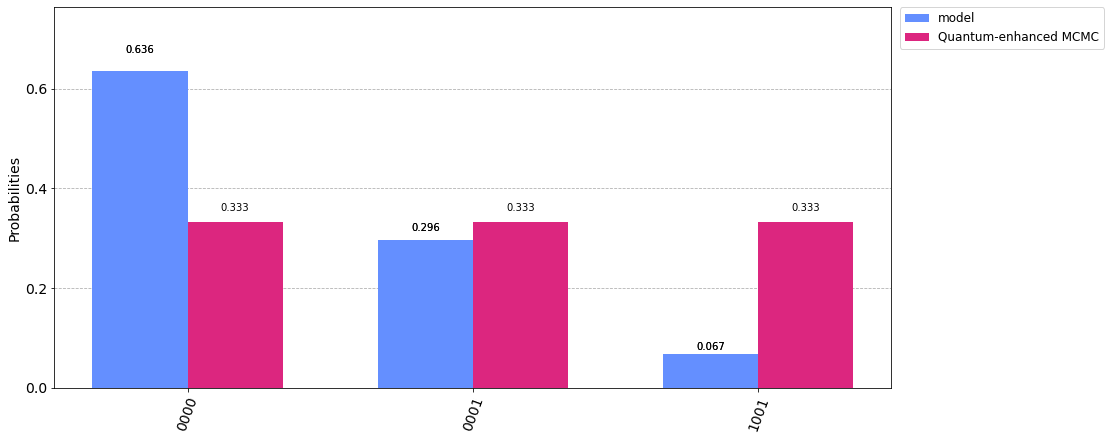

In [18]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=5
dict_states_quantum_mcmc, _, _=quantum_enhanced_mcmc(N_hops, 
num_spins, num_elems, model, alpha, num_trotter_steps=10, 
return_last_n_states=3,return_both_classical_and_quantum_steps=True)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in dict_states_quantum_mcmc.keys() ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [transits_bltz, dict_states_quantum_mcmc] , figsize=(15, 7), legend= ['model', 'Quantum-enhanced MCMC' ])#, sort= 'value_desc')

In [13]:
dict_states_quantum_mcmc

(Counter({'0010': 1, '0001': 2}),
   acceptance    energy
 0       True -0.397840
 1       True -0.403041
 2       True  0.764179
 3      False  0.764179
 4       True  2.243997)